In [ ]:
  from IPython import display
from scipy.io import wavfile
import numpy as np
from numpy import fft
from matplotlib import pyplot as plt

In [ ]:
from scipy import signal

In [ ]:
display.Audio(url='data/gspi.wav')

In [ ]:
Fs, data = wavfile.read('data/gspi.wav')
print('Frekvencija uzorkovanja: ', Fs)
print('Uzorci: ', data.shape)

Frekvencija uzorkovanja:  44100
Uzorci:  (262144,)


In [ ]:
N = data.shape[0]
duration = N / Fs
n = 256

In [ ]:
window = np.hanning(n)
window.shape

(256,)

In [ ]:
hopsamp = 64

In [ ]:
def stft(data):
#     spectrogram = np.zeros((N-n, n),dtype=np.complex_)
#     for i in range(0, N-n):
#         samples = data[i : i+n ]
#         c = fft.fft(samples*window)
#         spectrogram[i, :] = c
# komentar vise test
    return signal.stft(data, Fs, nperseg = 256, window='nuttall', noverlap=224)[2]

In [ ]:
def istft(spectrogram):
#     x = np.zeros(N)
#     for i in range(0, N-n):
#         x[i : i+n] += window * np.real(fft.ifft(spectrogram[i]))
    return signal.istft(spectrogram, Fs, nperseg = 256, window='nuttall', noverlap=224)[1]

In [ ]:
def SSNR(x, s):
    e = np.sqrt(np.sum((np.abs(stft(x))-s)**2))
    e /= np.sqrt(np.sum(s**2))
    return -10 * np.log10(e)

In [ ]:
def pc1(c):
    return stft(istft(c))

def pc2(c, s):
    return s*np.exp(1.0j*np.angle(c))

In [ ]:
def GLA(s, N, iterations):
    x = np.zeros(N)

    c = s*np.exp(1.0j*np.angle(stft(x)))

    x = istft(c)

    ssnr_history = []

    for i in range(1,iterations+1):
        c = pc1(pc2(c,s))

        x = istft(c)

        ssnr = SSNR(x, s)
        if(i % 100 == 0):
            print('Reconstruction iteration: {}/{} - SSNR: {}'.format(i, iterations, ssnr))
        ssnr_history.append(ssnr)

    return x, ssnr_history

In [ ]:
def FGLA(s, N, iterations, alpha = 0.99):
    x = np.zeros(N)

    c_prev = s*np.exp(1.0j*np.angle(stft(x)))
    t_prev = pc2(pc1(c_prev),s)

    x = istft(c_prev)

    ssnr_history = []

    for i in range(1,iterations+1):
        t = pc1(pc2(c_prev,s))
        c = t + alpha*(t - t_prev)

        t_prev = t
        c_prev = c

        x = istft(c)

        ssnr = SSNR(x, s)
        if(i % 100 == 0):
            print('Reconstruction iteration: {}/{} - SSNR: {}'.format(i, iterations, ssnr))
        ssnr_history.append(ssnr)

    return x, ssnr_history


In [ ]:
alpha = 0.99
iterations = 1000

s = np.abs(stft(data))

print("### GLA: ")
x_gla, history_gla = GLA(s, N, iterations)

print("### FGLA: ")
x_fgla, history_fgla = FGLA(s, N, iterations, alpha)

### GLA: 
Reconstruction iteration: 100/1000 - SSNR: 8.994647017530422
Reconstruction iteration: 200/1000 - SSNR: 10.071348194151641
Reconstruction iteration: 300/1000 - SSNR: 10.450507623687066
Reconstruction iteration: 400/1000 - SSNR: 11.02373399829455
Reconstruction iteration: 500/1000 - SSNR: 11.225242276427775
Reconstruction iteration: 600/1000 - SSNR: 11.362363881915325
Reconstruction iteration: 700/1000 - SSNR: 11.469222697624526
Reconstruction iteration: 800/1000 - SSNR: 11.574924743623892
Reconstruction iteration: 900/1000 - SSNR: 11.657259777993072
Reconstruction iteration: 1000/1000 - SSNR: 11.727691461385891
### FGLA: 
Reconstruction iteration: 100/1000 - SSNR: 12.419462514152116
Reconstruction iteration: 200/1000 - SSNR: 13.773299399169883
Reconstruction iteration: 300/1000 - SSNR: 14.414987892212627
Reconstruction iteration: 400/1000 - SSNR: 14.795061854677481
Reconstruction iteration: 500/1000 - SSNR: 15.036453150387995
Reconstruction iteration: 600/1000 - SSNR: 15.2098

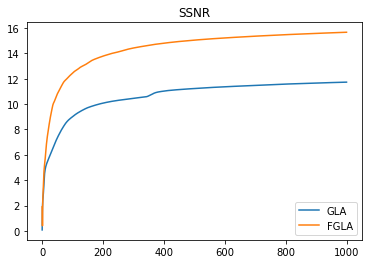

In [ ]:
it_vals = range(0, iterations)
plt.title('SSNR')
plt.plot(it_vals, history_gla, label='GLA')
plt.plot(it_vals, history_fgla, label='FGLA')
plt.legend(loc='best')

In [ ]:
# plt.imshow(np.flip(np.log(np.abs(stft(data)))).T, aspect='auto')
# plt.colorbar()
# plt.show()

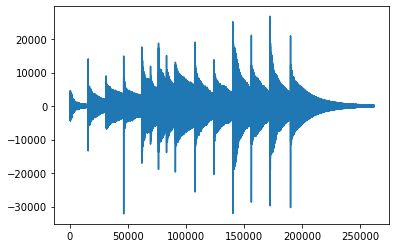

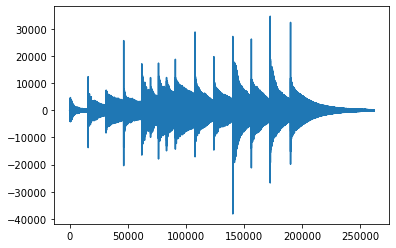

In [ ]:
plt.plot(data)
plt.show()
plt.plot(x_fgla)
plt.show()

In [ ]:
display.Audio(data=x_fgla, rate=Fs)